In [1]:
import json
import tweepy
from datetime import datetime
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


#authentication

consumer_key = "h2jljf5kymhIi4ZbysbSqTO6B"
consumer_secret = "a3zqrTN5oaveeWTVOGb3f58hHSXvQi2osTNwNPb3o06WD6B5Jr"
access_token = "3171917533-Zau2LdDFH4TtBEDLon0UkdOsUN1Rsvqp9Ah4naG"
access_token_secret = "XCeshjesDBWxYyHaTEcO97AcN89a8i7tN3qti4vZrD37y"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token("3171917533-Zau2LdDFH4TtBEDLon0UkdOsUN1Rsvqp9Ah4naG", "XCeshjesDBWxYyHaTEcO97AcN89a8i7tN3qti4vZrD37y")

api = tweepy.API(auth)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.6 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [2]:
from nltk.corpus import stopwords
#Preprocessing Function
def preprocess_tweet(tweet):
  tweet = re.sub(r'http\S+', '', tweet)
  # Remove mentions and hashtags
  tweet = re.sub(r'@\w+|#\w+', '', tweet)
  # Remove punctuation
  tweet = tweet.translate(str.maketrans('', '', string.punctuation))
  # Correct spelling using TextBlob
  tweet = str(TextBlob(tweet).correct())
  tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
  # Remove stopwords
  stop_words = set(stopwords.words('english'))
  stop_words.update(['rt', 'this', 'is', 'a', 'the','to','the','RT','for','were'])
  tokens = word_tokenize(tweet)
  tokens = [word for word in tokens if not word in stop_words]

  tagged = nltk.pos_tag(tokens)
  named_entities = nltk.ne_chunk(tagged) 
  named_entities = [chunk for chunk in named_entities if hasattr(chunk, 'label')]
  named_entities = [' '.join(c[0] for c in chunk.leaves()) for chunk in named_entities]

  for ne in named_entities:
    tweet = tweet.replace(ne, '')

    

  return tweet


   

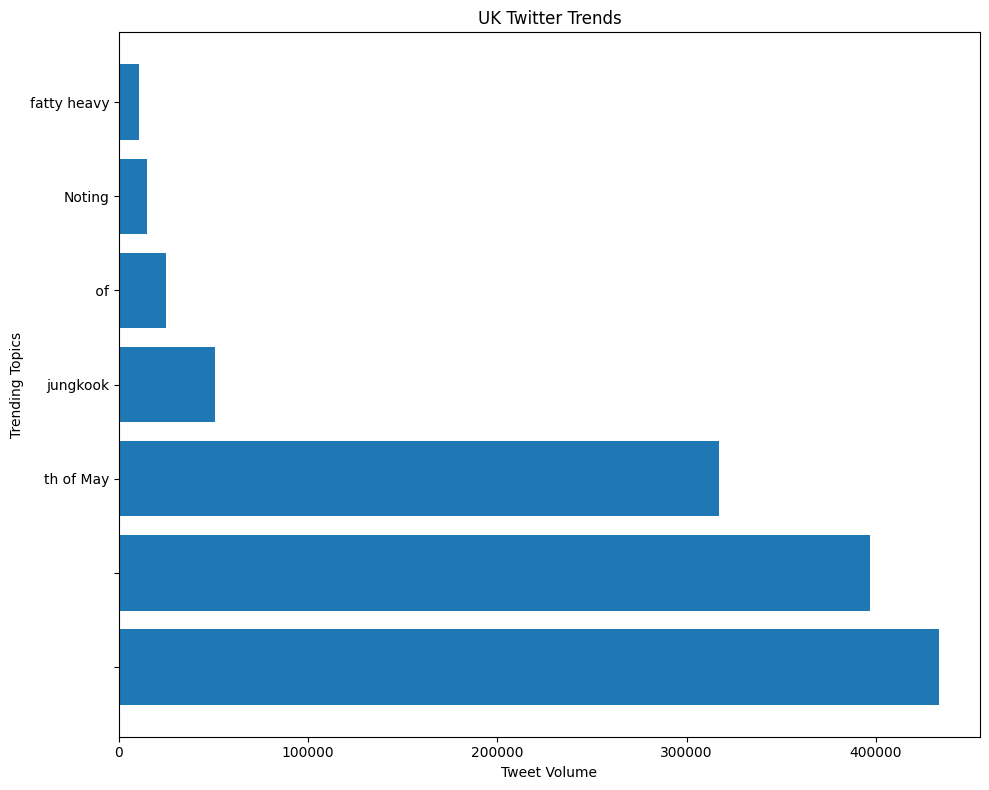

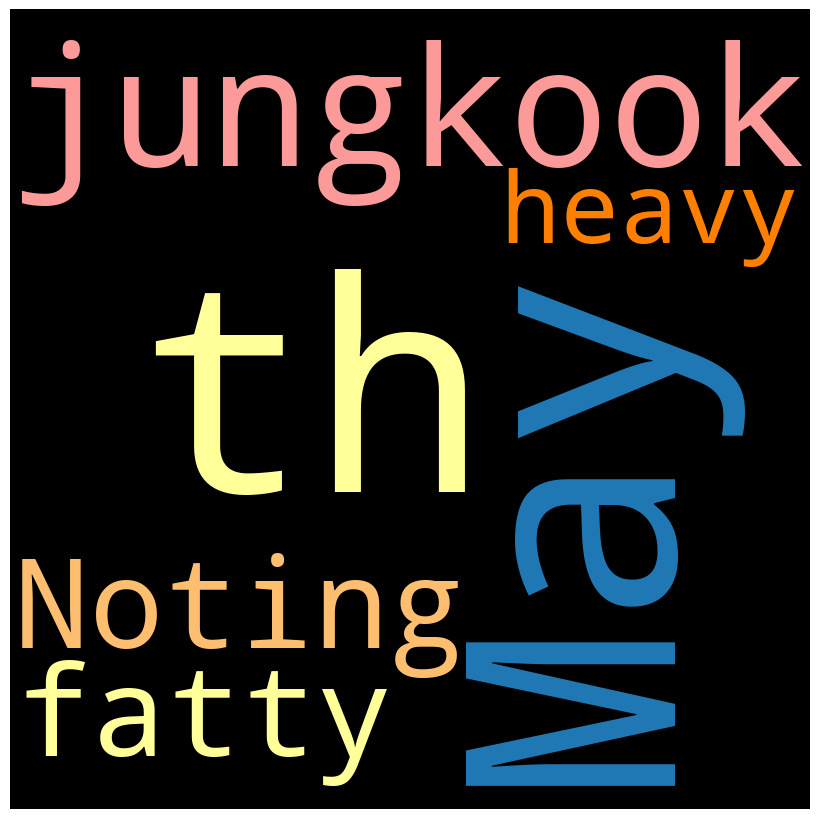

In [3]:
# Code to fetch trending tweets and wordcloud
# Extracting the trending topics
uk_trends = api.get_place_trends(23424975)


trends_data = uk_trends[0]['trends']
# Set minimum tweet volume threshold
min_tweet_volume = 10000

# Extracting the trending topic names and tweet volumes
trends = []
tweet_volumes = []
for trend in trends_data:
    if trend['tweet_volume'] and trend['tweet_volume'] >= min_tweet_volume:
        trends.append(preprocess_tweet(trend['name']))
        tweet_volumes.append(trend['tweet_volume'])

# Get the indices of the topics with no name
no_name_indices = [i for i, trend in enumerate(trends) if trend == '']

# Remove the topics with no name
trends = [trend for trend in trends if trend != '']
tweet_volumes = [tweet_volume for tweet_volume in tweet_volumes if tweet_volume >= min_tweet_volume]

# Add the names of the two topics with no name
if len(no_name_indices) == 2:
    trends.insert(no_name_indices[0], 'Topic 1')
    trends.insert(no_name_indices[1], 'Topic 2')
    tweet_volumes.insert(no_name_indices[0], 0)
    tweet_volumes.insert(no_name_indices[1], 0)

# Plotting the trending topics
sorted_trends, sorted_volumes = zip(*sorted(zip(trends, tweet_volumes), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(10,8))
plt.barh(range(len(sorted_trends)), sorted_volumes)
plt.yticks(range(len(sorted_trends)), sorted_trends)
plt.title("UK Twitter Trends")
plt.xlabel("Tweet Volume")
plt.ylabel("Trending Topics")
plt.tight_layout()
plt.show()

# Concatenate all the trend names into a single string
trends_text = ' '.join(sorted_trends)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='black', colormap='Paired').generate(trends_text)

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


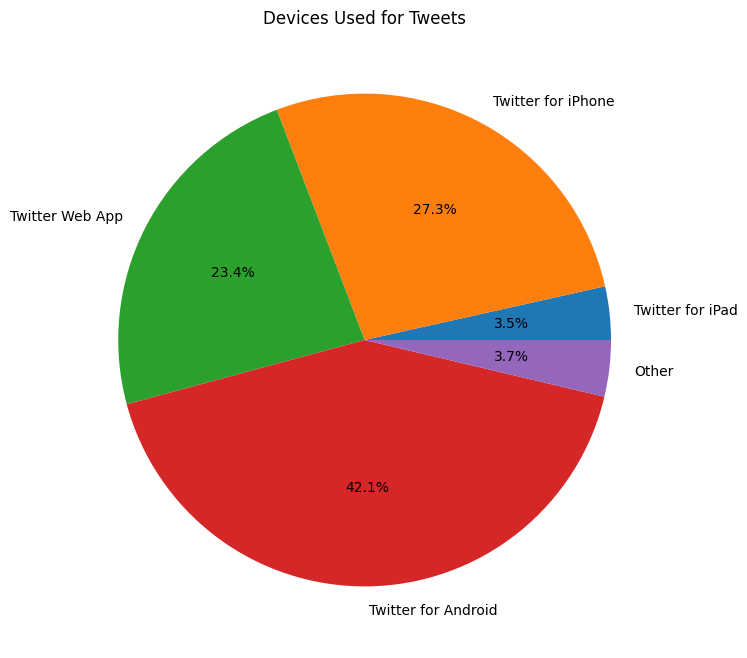

In [4]:
# Devices used for Tweet
trends_result = api.get_place_trends(23424975)
trends_text = trends_result[0]['trends'][0]['name']

# Get device source of tweets
num_tweets = 1000 # choose the number of tweets to extract
device_sources = []
for tweet in tweepy.Cursor(api.search_tweets, q=trends_text, lang='en').items(num_tweets):
    device_sources.append(tweet.source)
    
# Count the number of occurrences of each device source
device_counts = Counter(device_sources)

# Create a dictionary to hold the final counts
final_counts = {}

# Group devices with less than 1% usage into an "Other" category
total_count = sum(device_counts.values())
other_count = 0
for device, count in device_counts.items():
    if count / total_count >= 0.01:
        final_counts[device] = count
    else:
        other_count += count
final_counts['Other'] = other_count

# Plot the pie chart of device usage
plt.figure(figsize=(8,8))
plt.pie(final_counts.values(), labels=final_counts.keys(), autopct='%1.1f%%')
plt.title('Devices Used for Tweets')
plt.show()


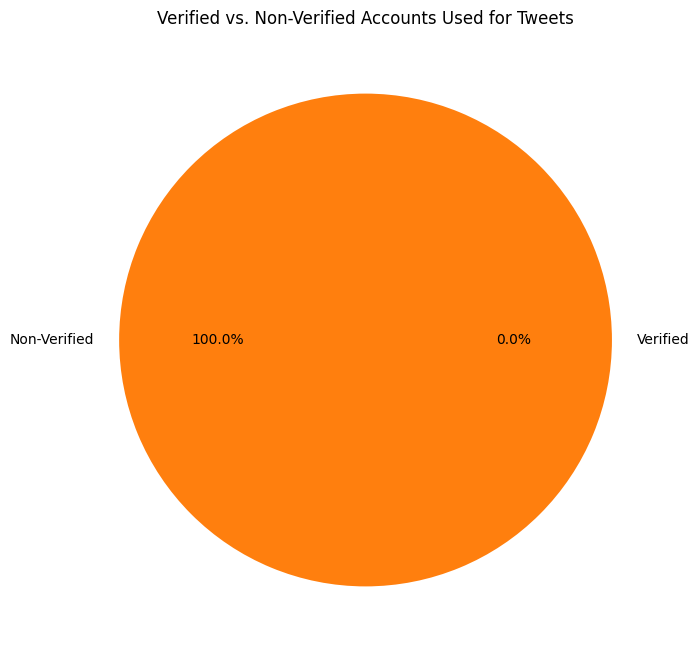

In [ ]:
# Source reliability code
uk_trends = api.get_place_trends(23424975)
trends_text = uk_trends[0]["trends"][0]["name"]

# Search for tweets containing the top trend in the UK
tweets = api.search_tweets(q=trends_text, lang="en", count=10000)

# Count the number of verified and non-verified users who tweeted about the trend
verified_counts = 0
non_verified_counts = 0

for tweet in tweets:
    if tweet.user.verified:
        verified_counts += 1
    else:
        non_verified_counts += 1

# Plot the pie chart of verified and non-verified account counts
plt.figure(figsize=(8,8))
plt.pie([verified_counts, non_verified_counts], labels=['Verified', 'Non-Verified'], autopct='%1.1f%%')
plt.title('Verified vs. Non-Verified Accounts Used for Tweets')
plt.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 45.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatibl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 46.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatibl

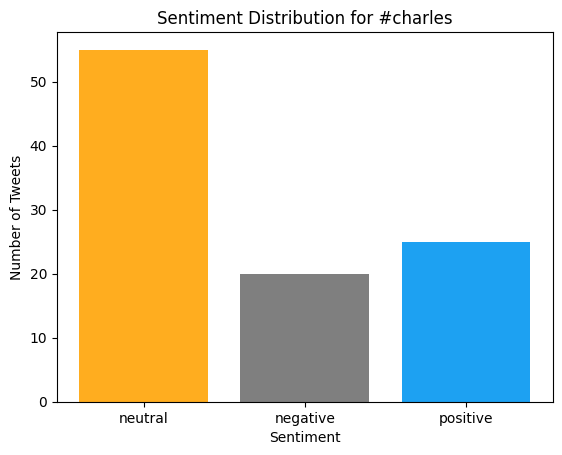

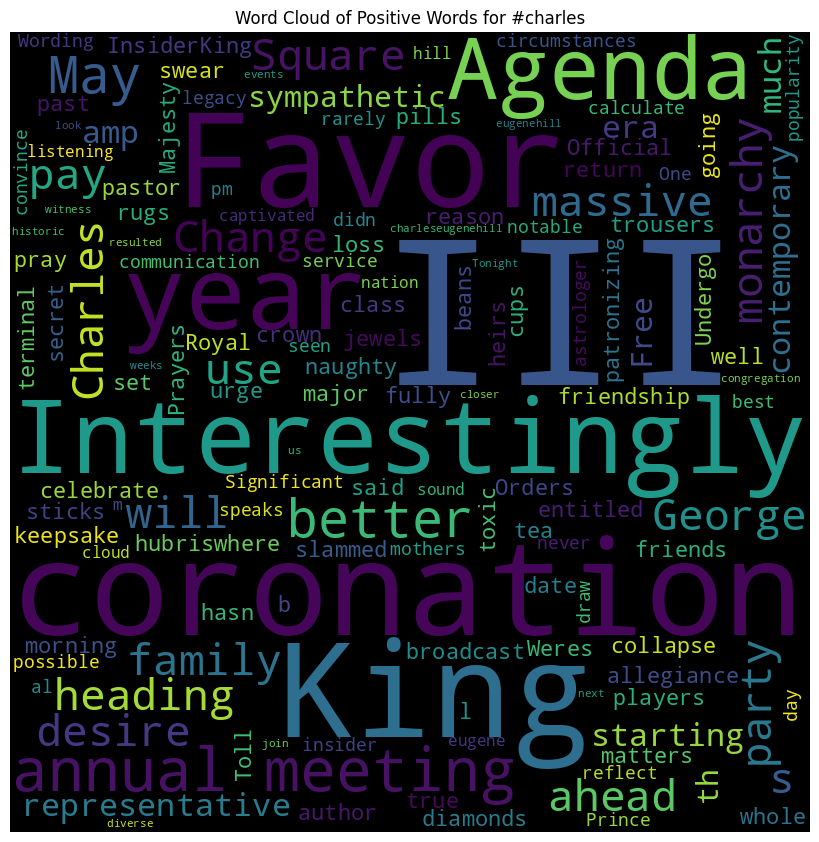

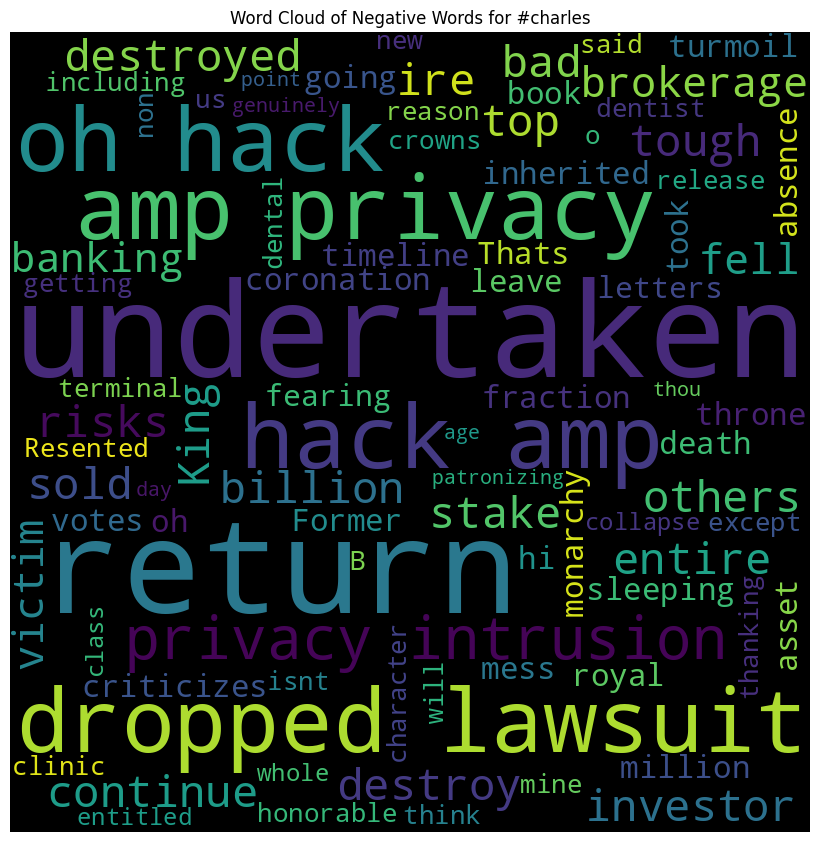

<ipython-input-5-582b09efb61b>:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([word[0] for word in top_positive_words], rotation=45, ha='right')


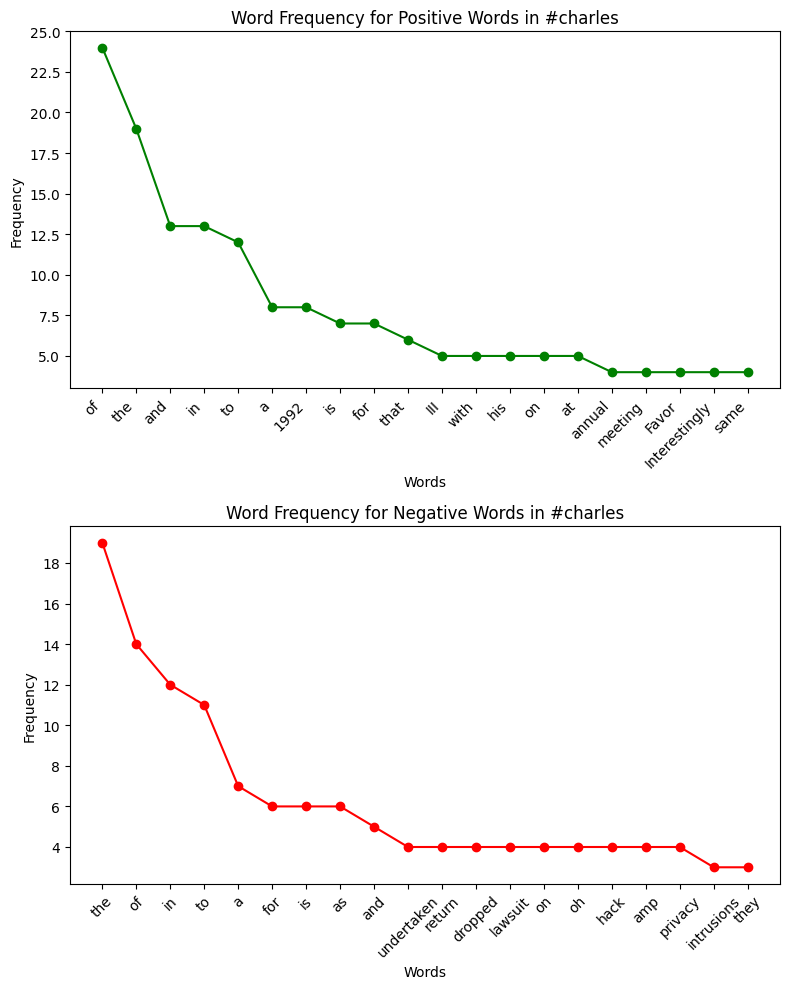

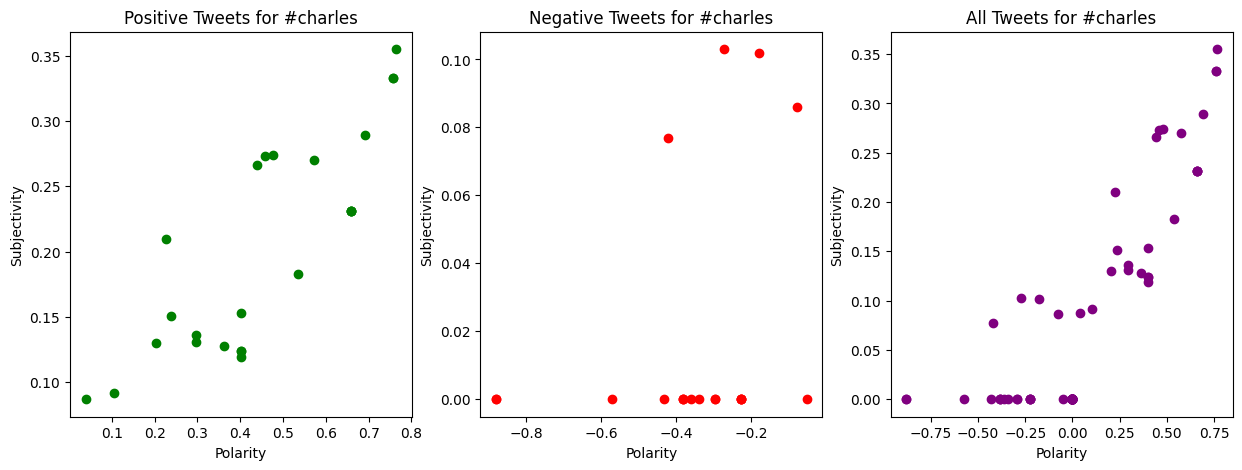

In [5]:
#code for sentiment Intensity analysis
!pip install --upgrade pandas pyLDAvis joblib

# Set up VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()
from nltk.sentiment import util
def get_tweet_sentiment(tweet):
    sentiment = analyzer.polarity_scores(tweet)
    if sentiment['compound'] > 0:
        return 'positive'
    elif sentiment['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

# Fetch tweets with hashtag #charles
tweets = api.search_tweets(q='#charles', lang='en', count=1000)


# Extract text from tweets and preprocess
preprocessed_tweets = [preprocess_tweet(tweet.text) for tweet in tweets]

# Get sentiment for each tweet
sentiments = [get_tweet_sentiment(tweet) for tweet in preprocessed_tweets]

# Plot sentiment distribution as pie chart
sentiment_counts = dict(Counter(sentiments))
fig, ax = plt.subplots()
ax.bar(sentiment_counts.keys(), sentiment_counts.values(), color=['#ffad1f', '#7f7f7f', '#1da1f2'])
ax.set_xlabel('Sentiment')
ax.set_ylabel('Number of Tweets')
ax.set_title('Sentiment Distribution for #charles')
plt.show()

# Calculate polarity and subjectivity scores for each tweet
# Get positive tweets for generating word cloud
positive_tweets = [preprocessed_tweets[i] for i in range(len(sentiments)) if sentiments[i] == 'positive']

# Generate word cloud of positive words
positive_words = ' '.join(positive_tweets)
wordcloud = WordCloud(width=800, height=800, background_color='black').generate(positive_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud of Positive Words for #charles')
# Show the word cloud of positive words
plt.show()

# Get negative tweets for generating word cloud
negative_tweets = [preprocessed_tweets[i] for i in range(len(sentiments)) if sentiments[i] == 'negative']

# Generate word cloud of negative words
negative_words = ' '.join(negative_tweets)
wordcloud = WordCloud(width=800, height=800, background_color='black').generate(negative_words)
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Word Cloud of Negative Words for #charles')
plt.show()
from collections import Counter

# Separate positive and negative tweets
positive_tweets = [preprocessed_tweets[i] for i in range(len(sentiments)) if sentiments[i] == 'positive']
negative_tweets = [preprocessed_tweets[i] for i in range(len(sentiments)) if sentiments[i] == 'negative']

# Combine all positive and negative tweets into a single string
positive_words = ' '.join(positive_tweets)
negative_words = ' '.join(negative_tweets)

# Tokenize the strings into words
positive_words = nltk.word_tokenize(positive_words)
negative_words = nltk.word_tokenize(negative_words)

# Count the frequency of each word
positive_word_counts = Counter(positive_words)
negative_word_counts = Counter(negative_words)

# Get the most common 20 words for positive and negative words
top_positive_words = positive_word_counts.most_common(20)
top_negative_words = negative_word_counts.most_common(20)

# Plot line graphs of the word frequencies for positive and negative words
# Plot line graphs of the word frequencies for positive and negative words
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
axs[0].plot([word[0] for word in top_positive_words], [word[1] for word in top_positive_words], marker='o', color='green')
axs[0].set_xlabel('Words')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Word Frequency for Positive Words in #charles')
axs[0].set_xticklabels([word[0] for word in top_positive_words], rotation=45, ha='right')



axs[1].plot([word[0] for word in top_negative_words], [word[1] for word in top_negative_words], marker='o', color='red')
axs[1].set_xlabel('Words')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Word Frequency for Negative Words in #charles')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
polarity_scores = [analyzer.polarity_scores(tweet)['compound'] for tweet in preprocessed_tweets]
subjectivity_scores = [analyzer.polarity_scores(tweet)['pos'] for tweet in preprocessed_tweets]
positive_polarity = [analyzer.polarity_scores(tweet)['compound'] for tweet in positive_tweets]
positive_subjectivity = [analyzer.polarity_scores(tweet)['pos'] for tweet in positive_tweets]

negative_polarity = [analyzer.polarity_scores(tweet)['compound'] for tweet in negative_tweets]
negative_subjectivity = [analyzer.polarity_scores(tweet)['pos'] for tweet in negative_tweets]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter(positive_polarity, positive_subjectivity, color='green')
axs[0].set_xlabel('Polarity')
axs[0].set_ylabel('Subjectivity')
axs[0].set_title('Positive Tweets for #charles')

axs[1].scatter(negative_polarity, negative_subjectivity, color='red')
axs[1].set_xlabel('Polarity')
axs[1].set_ylabel('Subjectivity')
axs[1].set_title('Negative Tweets for #charles')

axs[2].scatter(polarity_scores, subjectivity_scores, color='purple')
axs[2].set_xlabel('Polarity')
axs[2].set_ylabel('Subjectivity')
axs[2].set_title('All Tweets for #charles')

plt.show()



In [6]:
#Article analysis
import requests
import json
import re
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Correct spelling using TextBlob
    text = str(TextBlob(text).correct())
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if not word in stopwords.words('english')]

    tagged = nltk.pos_tag(tokens)
    named_entities = nltk.ne_chunk(tagged)
    named_entities = [chunk for chunk in named_entities if hasattr(chunk, 'label')]
    named_entities = [' '.join(c[0] for c in chunk.leaves()) for chunk in named_entities]
    
    for ne in named_entities:
        text = text.replace(ne, '')
    
    return text

# Fetch articles from API
url = "http://api.mediastack.com/v1/news"
params = {
    #change this access token
    "access_key": "9a85d65a4580b4593fd7a92af152ce30",
    "keywords": "Jerry Springer",
    "countries": "us",
}
response = requests.get(url, params=params)

# Parse JSON response
articles = json.loads(response.text)['data']

# Clean and preprocess articles
cleaned_articles = []
for article in articles:
    description = article['description']
    cleaned_description = preprocess_text(description)
    cleaned_article = {
        'title': article['title'],
        'description': cleaned_description
    }
    cleaned_articles.append(cleaned_article)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


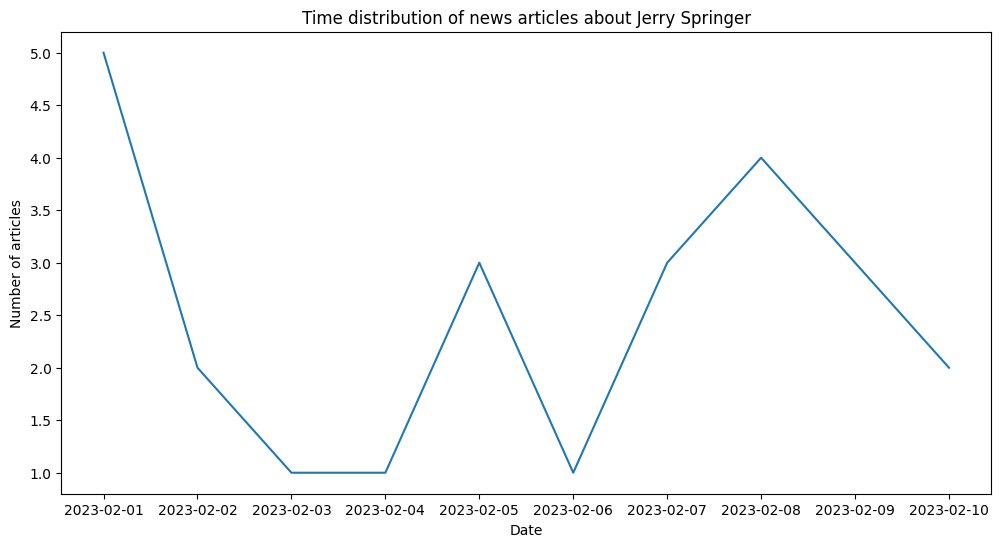

In [7]:
#time distribution of articles
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Fetch news articles
url = "http://api.mediastack.com/v1/news"
params = {
    "access_key": "9a85d65a4580b4593fd7a92af152ce30",
    "keywords": "jerry springer",
    "countries": "us"
}
response = requests.get(url, params=params)
articles = response.json()["data"]

# Convert published_at to datetime
dates = [pd.to_datetime(article["published_at"]).date() for article in articles]

# Create a DataFrame of article counts by date
df = pd.DataFrame({"count": 1}, index=dates)
counts = df.groupby(df.index).count()

# Plot time distribution
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(counts.index, counts["count"])
ax.set_xlabel("Date")
ax.set_ylabel("Number of articles")
ax.set_title("Time distribution of news articles about Jerry Springer")
plt.show()


In [ ]:
pip install python-louvain --upgrade


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Top 10 nodes based on clustering coefficient:
       id  clustering
71     44         1.0
503   351         1.0
508  1122         1.0
524  1125         1.0
557  1133         1.0
574  1046         1.0
575  1047         1.0
576  1048         1.0
577  1049         1.0
665   707         1.0

Top 10 nodes based on degree:
      id  degree
21     8      54
397  481      51
18    18      43
390  346      41
55    33      39
147   99      39
104  151      33
10    63      31
239  302      31
29    23      30

Top 10 nodes based on degree centrality:
      id  degree_centrality
21     8           0.020408
397  481           0.019274
18    18           0.016251
390  346           0.015495
55    33           0.014739
147   99           0.014739
104  151           0.012472
10    63           0.011716
239  302           0.011716
29    23           0.011338

Top 10 nodes based on closeness centrality:
     id  closeness
21    8   0.195165
29   23   0.169903
27   21   0.169572
7    13   0.167177
25  

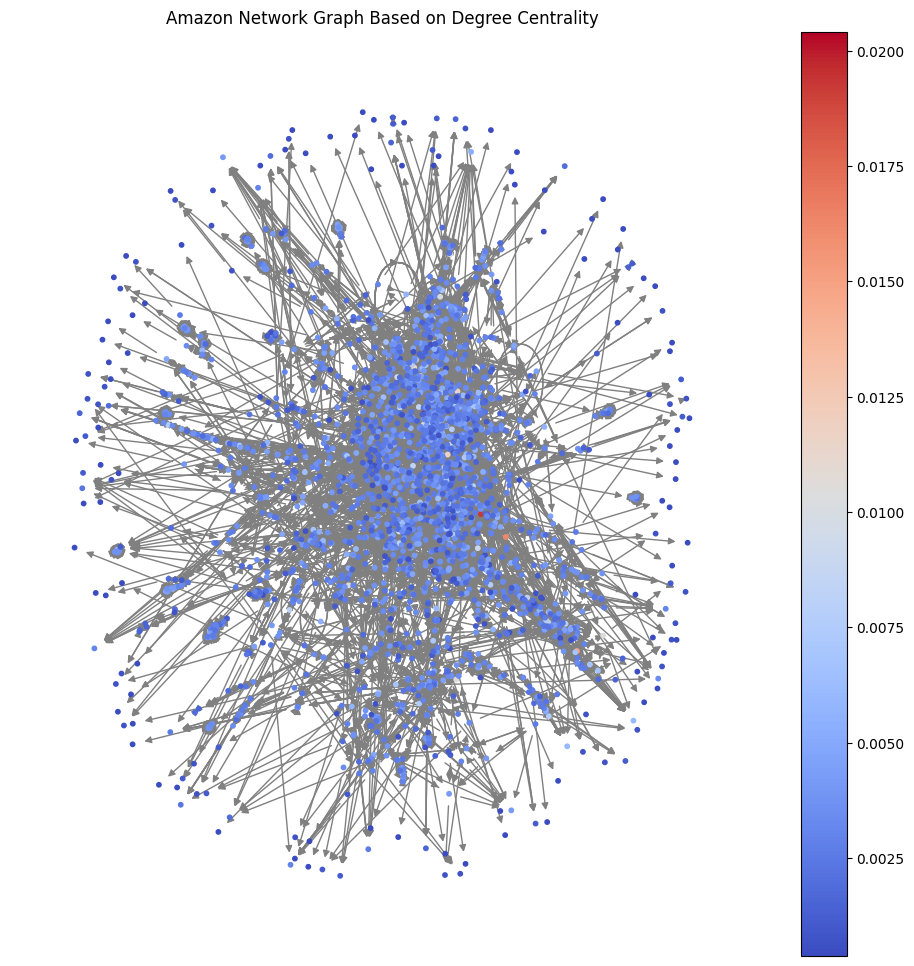

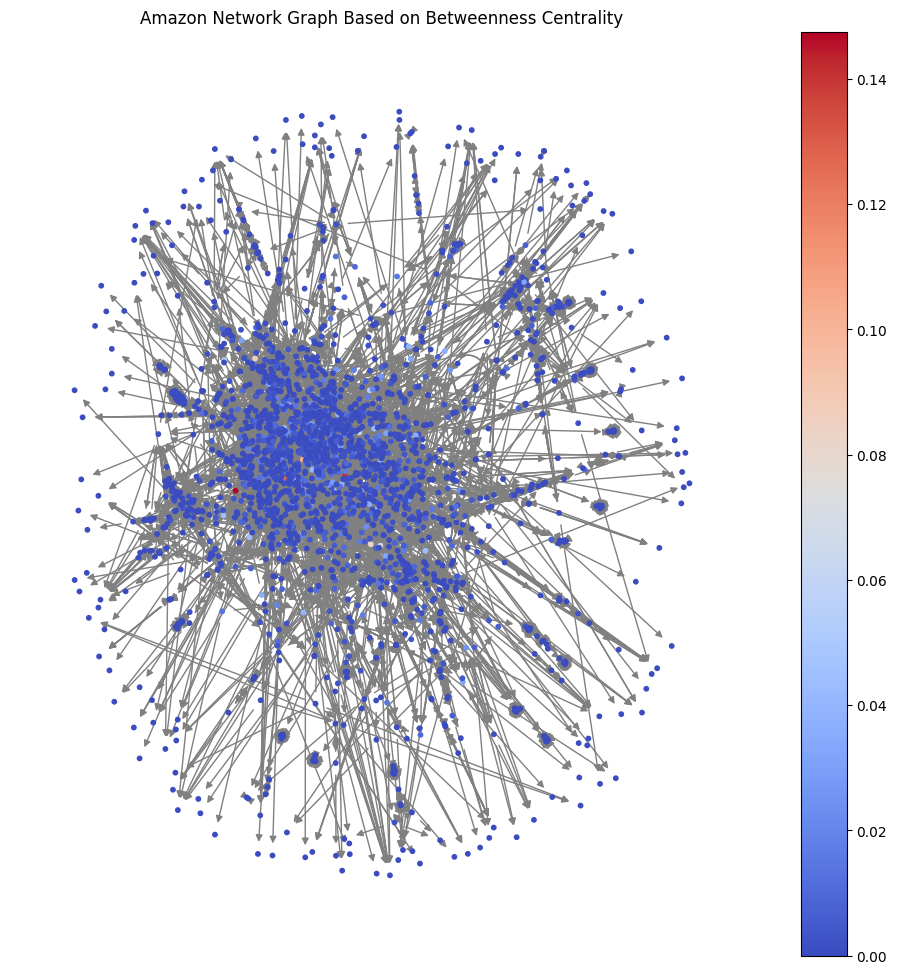

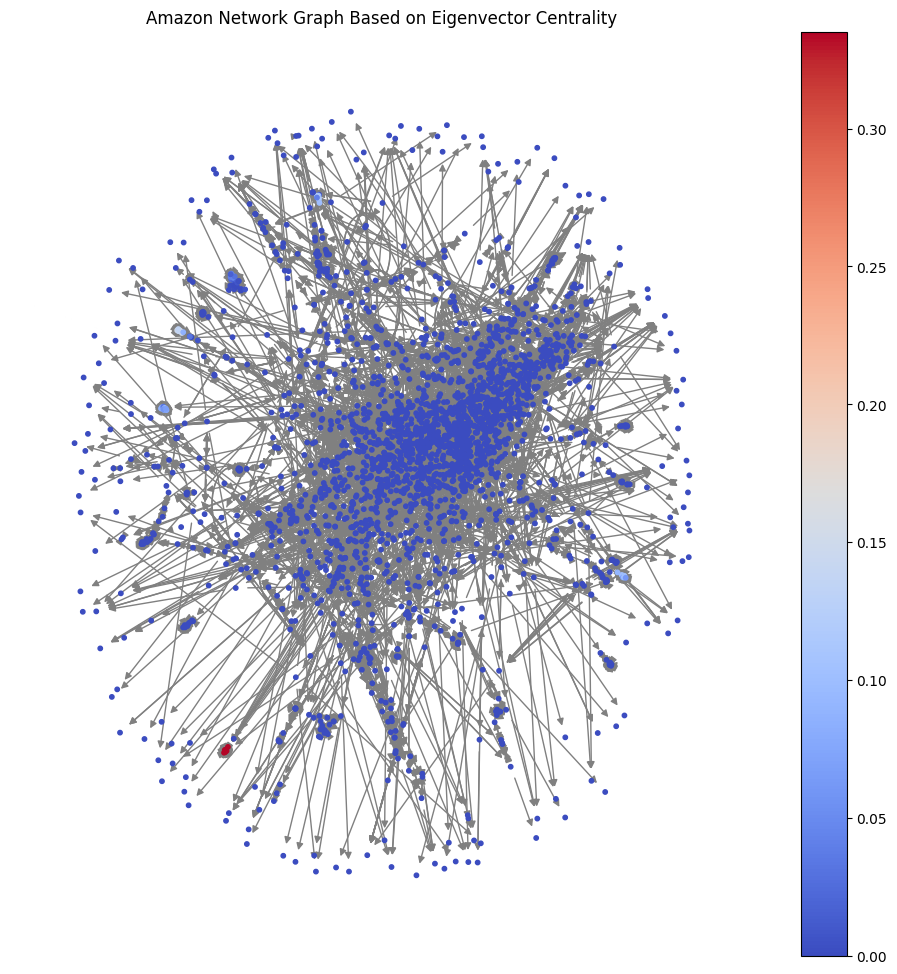

AttributeError: ignored

In [ ]:
# code for centrality
#upload the csv file into runtime
import networkx as nx
import pandas as pd
from matplotlib.pyplot import subplots

# Read in the csv file and create a directed graph
df = pd.read_csv("/content/amazonNetwork.csv")
G = nx.from_pandas_edgelist(df, source='FromNodeId', target='ToNodeId', create_using=nx.DiGraph())

# Calculate different centrality measures
clustering = nx.clustering(G)
degree = G.degree()
degree_centrality = nx.degree_centrality(G)
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
eigenvector = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)

# Create a dataframe with centrality measures for each node
df_cent = pd.DataFrame({
    'id': list(G.nodes()),
    'clustering': [clustering[node] for node in G.nodes()],
    'degree': [degree[node] for node in G.nodes()],
    'degree_centrality': [degree_centrality[node] for node in G.nodes()],
    'closeness': [closeness[node] for node in G.nodes()],
    'betweenness': [betweenness[node] for node in G.nodes()],
    'eigenvector': [eigenvector[node] for node in G.nodes()]
})

# Get the top 10 nodes for each centrality measure
top_clustering = df_cent.nlargest(10, 'clustering')
top_degree = df_cent.nlargest(10, 'degree')
top_degree_centrality = df_cent.nlargest(10, 'degree_centrality')
top_closeness = df_cent.nlargest(10, 'closeness')
top_betweenness = df_cent.nlargest(10, 'betweenness')
top_eigenvector = df_cent.nlargest(10, 'eigenvector')

# Print the results
print("Top 10 nodes based on clustering coefficient:")
print(top_clustering[['id', 'clustering']])
print("\nTop 10 nodes based on degree:")
print(top_degree[['id', 'degree']])
print("\nTop 10 nodes based on degree centrality:")
print(top_degree_centrality[['id', 'degree_centrality']])
print("\nTop 10 nodes based on closeness centrality:")
print(top_closeness[['id', 'closeness']])
print("\nTop 10 nodes based on betweenness centrality:")
print(top_betweenness[['id', 'betweenness']])
print("\nTop 10 nodes based on eigenvector centrality:")
print(top_eigenvector[['id', 'eigenvector']])

# Plot the graph for degree centrality
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.coolwarm, node_color=list(degree_centrality.values()))
edges = nx.draw_networkx_edges(G, pos, edge_color='gray')
plt.title("Amazon Network Graph Based on Degree Centrality")
plt.colorbar(nodes)
plt.axis('off')
plt.show()

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.coolwarm, node_color=list(betweenness.values()))
edges = nx.draw_networkx_edges(G, pos, edge_color='gray')
plt.title("Amazon Network Graph Based on Betweenness Centrality")
plt.colorbar(nodes)
plt.axis('off')
plt.show()

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nodes = nx.draw_networkx_nodes(G, pos, node_size=10, cmap=plt.cm.coolwarm, node_color=list(eigenvector.values()))
edges = nx.draw_networkx_edges(G, pos, edge_color='gray')
plt.title("Amazon Network Graph Based on Eigenvector Centrality")
plt.colorbar(nodes)
plt.axis('off')
plt.show()




import community

# Convert the directed graph to undirected
G_undir = G.to_undirected()

# Find the communities using Louvain method
partition = community.best_partition(G_undir)

# Print the number of communities
print(f"Number of communities: {len(set(partition.values()))}")

# Visualize the communities
# Set up the plot
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_undir)

# Draw the nodes colored by community
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G_undir, pos, partition.keys(), node_size=50, cmap=cmap, node_color=list(partition.values()))

# Draw the edges
nx.draw_networkx_edges(G_undir, pos, alpha=0.5)

# Add a title to the plot
plt.title("Amazon Network Graph with Communities")

# Add a colorbar legend to indicate community names
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max(partition.values())))
sm._A = []
plt.colorbar(sm, ticks=range(len(set(partition.values()))))
plt.show()

G = nx.from_pandas_edgelist(df, source='FromNodeId', target='ToNodeId',create_using=nx.DiGraph()) 
plt.rcParams['figure.figsize'] = 20, 20

nx.draw(G)

In [8]:
#count of words,sentenses
import pandas as pd

# Fetch news articles
url = "http://api.mediastack.com/v1/news"
params = {
    "access_key": "9a85d65a4580b4593fd7a92af152ce30",
    "keywords": "jerry springer",
    "countries": "us"
}
response = requests.get(url, params=params)
articles = response.json()["data"]

# Convert published_at to datetime
dates = [pd.to_datetime(article["published_at"]).date() for article in articles]

# Create a DataFrame of article counts by date
df = pd.DataFrame({"count": 1}, index=dates)
counts = df.groupby(df.index).count()

# Create a DataFrame of the top 10 articles
df = pd.DataFrame(articles)
df["published_at"] = pd.to_datetime(df["published_at"])
df = df.nlargest(10, "published_at")

# Get the words and sentences for each article
article_data = []
for i, article in df.iterrows():
    words = article["title"].split()
    sentences = article["description"].split(".")
    article_data.append([article["published_at"].date(), article["title"], len(words), len(sentences)])

# Create a DataFrame of the article data
df_articles = pd.DataFrame(article_data, columns=["published_at", "title", "word_count", "sentence_count"])
print(df_articles)


  published_at                                              title  word_count   
0   2023-02-10  Jerry Lawler heading home from hospital after ...           9  \
1   2023-02-10  Jerry Lawler Health Update: WWE Hall of Famer ...          24   
2   2023-02-09  Deion Sanders Told Us His Favorite Jerry Jones...           9   
3   2023-02-09  Eagles owner was confused by comment Jerry Jon...           9   
4   2023-02-09           CYBER: What's the Deal With AI Seinfeld?           7   
5   2023-02-08  WWE Hall of Famer Jerry Lawler Expected to Ful...          12   
6   2023-02-08       Crockett edges Tarkington 58-53 in foul-fest           6   
7   2023-02-08  ‘It Was Good To See Us Transform:’ Zach Gentry...          20   
8   2023-02-08  Li Metal : Transport industry leaders share 20...          11   
9   2023-02-07  ‘Bosch’ Spinoffs Focused on Jerry Edgar, Renee...          14   

   sentence_count  
0               3  
1               2  
2               2  
3               6  
4       

In [16]:
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel

# Tokenize and preprocess the articles
processed_articles = [simple_preprocess(article['description']) for article in articles if 'description' in article and article['description']]

# Create a dictionary from the tokenized articles
dictionary = Dictionary(processed_articles)

# Filter out extreme values from the dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Convert tokenized articles into bag of words format
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_articles]

# Train the LDA model
lda_model = LdaModel(bow_corpus, num_topics=7, id2word=dictionary, passes=4)

# Get the topic words and their weights
topic_data = []
for i in range(lda_model.num_topics):
    topic_words = [word for word, weight in lda_model.show_topic(i)]
    topic_weights = [weight for word, weight in lda_model.show_topic(i)]
    topic_data.append([i, topic_words, topic_weights])

# Create a DataFrame of the topic data
df_topics = pd.DataFrame(topic_data, columns=["topic", "words", "weights"])
print(df_topics)



   topic                                              words   
0      0  [for, dallas, his, cowboys, jones, owner, with...  \
1      1  [this, at, was, left, his, more, than, and, to...   
2      2  [jones, to, was, that, and, owner, he, it, fir...   
3      3   [is, was, from, for, at, to, he, has, and, than]   
4      4  [to, and, with, that, first, he, by, at, this,...   
5      5  [and, for, to, at, left, his, this, was, by, f...   
6      6  [cowboys, that, jones, to, bowl, he, has, with...   

                                             weights  
0  [0.10854325, 0.10853723, 0.1045012, 0.10449334...  
1  [0.13219488, 0.1319896, 0.10903449, 0.10892618...  
2  [0.13385849, 0.09052334, 0.08993403, 0.0898326...  
3  [0.15926638, 0.10871385, 0.10758239, 0.1075636...  
4  [0.20206952, 0.16640474, 0.13759476, 0.1017765...  
5  [0.16018538, 0.10468174, 0.1041584, 0.06240929...  
6  [0.09715489, 0.09027798, 0.08186615, 0.0779474...  


In [ ]:
#coherence scores
import requests
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# Fetch news articles
url = "http://api.mediastack.com/v1/news"
params = {
    "access_key": "",
    "keywords": "jerry springer",
    "countries": "uk"
}
response = requests.get(url, params=params)
articles = response.json()["data"]

# Tokenize and preprocess the text
texts = []
for article in articles:
    tokens = article["title"].lower().split()
    texts.append(tokens)

# Create a dictionary and corpus for the topic model
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Experiment with different hyperparameters
num_topics = 10
passes = 10
iterations = 100
coherence_scores = []

for i in range(2, num_topics+1):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=i, passes=passes, iterations=iterations)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"Number of topics: {i}, Coherence Score: {coherence_score:.3f}")

# Plot coherence scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, num_topics+1), coherence_scores)
plt.title("Coherence Scores vs. Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.show()

# Choose the number of topics with the highest coherence score
num_topics = coherence_scores.index(max(coherence_scores)) + 2

# Train the final topic model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes, iterations=iterations)

# Combine the word frequencies from all the topics
all_topic_words = dict()
for i in range(lda_model.num_topics):
    topic_words = dict(lda_model.show_topic(i, 30))
    for word, freq in topic_words.items():
        if word in all_topic_words:
            all_topic_words[word] += freq
        else:
            all_topic_words[word] = freq

# Sort the words by frequency
sorted_words = sorted(all_topic_words.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_words[:20]




In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine the word frequencies from all the topics
all_topic_words = dict()
for i in range(lda_model.num_topics):
    topic_words = dict(lda_model.show_topic(i, 30))
    for word, freq in topic_words.items():
        if word in all_topic_words:
            all_topic_words[word] += freq
        else:
            all_topic_words[word] = freq

# Create a word cloud from the combined word frequencies
wc = WordCloud(background_color='black', width=800, height=600)
wc.generate_from_frequencies(all_topic_words)
plt.figure(figsize=(10, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Combined Topic Word Cloud")
plt.show()


In [ ]:
#top 20 topics
import matplotlib.pyplot as plt

# Combine the word frequencies from all the topics
all_topic_words = dict()
for i in range(lda_model.num_topics):
    topic_words = dict(lda_model.show_topic(i, 30))
    for word, freq in topic_words.items():
        if word in all_topic_words:
            all_topic_words[word] += freq
        else:
            all_topic_words[word] = freq

# Sort the words by frequency
sorted_words = sorted(all_topic_words.items(), key=lambda x: x[1], reverse=True)
top_words = sorted_words[:20]

# Create a line chart of the top 20 words
plt.figure(figsize=(12, 6))
plt.plot([word for word, freq in top_words], [freq for word, freq in top_words], marker='o')
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Topic Words by Frequency")
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.show()
